In [1]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import LabelEncoder
import warnings


In [2]:
### Modeling 시 발생하는 Warning Message 무시하기 위한 과정 ###

warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
if not sys.warnoptions:
	warnings.simplefilter("ignore")			
	os.environ["PYTHONWARNINGS"] = "ignore"	

	warnings.filterwarnings('ignore', 'Solver terminated early.*')
	warnings.filterwarnings('ignore', category=ConvergenceWarning)

#### 파일 불러오기 


In [3]:

df = pd.read_csv('All+position+S+values.csv',header=None)
cols = ['f1', 'f2', 'f2','f3', 'label']
df.columns = cols
df.head()


,f1,f2,f2,f3,label
0,0.275918,0.724082,0.3104,0.6896,1
1,0.281718,0.718282,0.3044,0.6956,1
2,0.277118,0.722882,0.3096,0.6904,1
3,0.277718,0.722282,0.3090,0.6910,1
4,0.279118,0.720882,0.3086,0.6914,1


#### Data Set Split
    - Train, Test Data 8:2 로 분할 후
    - 각 Data StandardScaler 사용하여 평균 0, 분산 1 로 조정한다.

In [4]:

# data_split : 전체 data 분할 및 label 설정하는 함수
def data_split(input_df, y_col = 'label'):
    """ 
    input df : 학습에 사용할 입력 변수, 분류 범주가 모두 포함 된 Data Frame

    y_col : input_df 중 label에 해당하는 Column name
    """

    train_test_dict = dict()
    data_x = input_df.drop([y_col], axis=1) # input data 중 y_col에 해당하는 열 drop 하여 입력 변수에 해당하는 Data만 남김
    y = input_df[y_col]# input data 중 y_col 에 해당하는 Data, y에 할당

    scaler = StandardScaler()

    encoder = LabelEncoder()

    # X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
    y = encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(data_x.values, y, test_size=0.2, random_state=2020,shuffle=True, stratify=y)
    scaler.fit(X_train)
    scaled_x_train = scaler.transform(X_train)
    scaled_x_test = scaler.transform(X_test)

    train_test_dict['test_x'] = scaled_x_test
    train_test_dict['test_y'] = y_test
    train_test_dict['train_x'] = scaled_x_train
    train_test_dict['train_y'] = y_train

    return train_test_dict

train_test_dict = data_split(input_df=df, y_col='label')

### KNN Classifier Hyperparams tuning

- neighbor 수 1~20 까지 확인하며 최적의 neighbor 개수 찾는다.

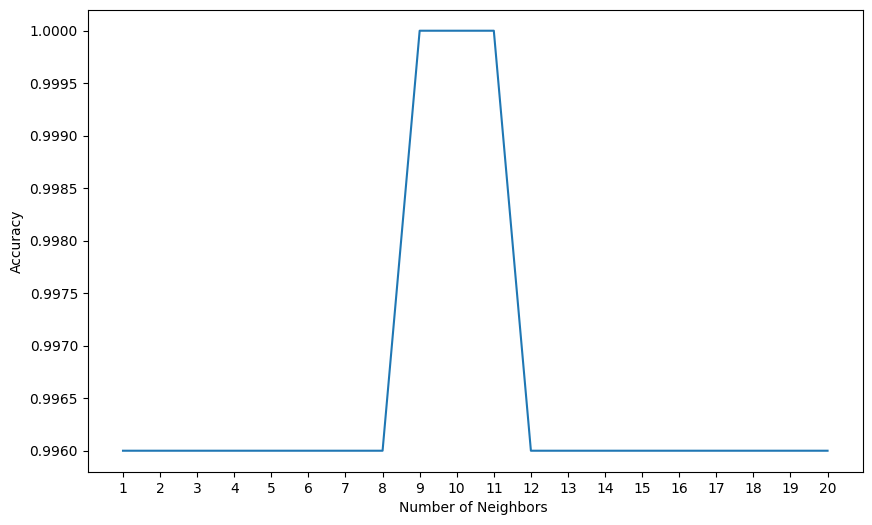

[(9, 1.0), (10, 1.0), (11, 1.0), (1, 0.996), (2, 0.996), (3, 0.996), (4, 0.996), (5, 0.996), (6, 0.996), (7, 0.996), (8, 0.996), (12, 0.996), (13, 0.996), (14, 0.996), (15, 0.996), (16, 0.996), (17, 0.996), (18, 0.996), (19, 0.996), (20, 0.996)]


In [5]:
knn = KNeighborsClassifier()
mean_acc = np.zeros(20)

for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors = i).fit(train_test_dict['train_x'],train_test_dict['train_y'])
    yhat= knn.predict(train_test_dict['test_x'])
    mean_acc[i-1] = accuracy_score(train_test_dict['test_y'], yhat)

loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()
mean_acc_key = [(n+1, v) for n, v in enumerate(mean_acc)]
mean_acc_key.sort(key=lambda x:([x[1], -x[0]]), reverse=True)
print(mean_acc_key)


In [6]:
neighbors = [n for n,v in mean_acc_key[:3]]
neighbors

[9, 10, 11]

In [7]:
knn_grid_params = {'n_neighbors' : neighbors,
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
knncv = GridSearchCV(KNeighborsClassifier(), knn_grid_params, verbose = 1, cv=3, n_jobs = -1)

knn_res = knncv.fit(train_test_dict['train_x'], train_test_dict['train_y'])
print(knn_res.best_score_)
print('best_params:',knn_res.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
0.9980009950069831
best_params: {'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}


#### KNN Classifier Modeling

- Best params : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

Training set accuracy:  1.0
Test set accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      

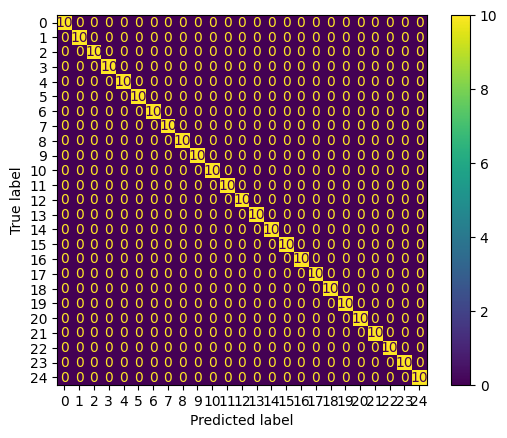

In [8]:
knn = KNeighborsClassifier(**knn_res.best_params_)
knn.fit(train_test_dict['train_x'], train_test_dict['train_y'])
y_hat = knn.predict(train_test_dict['train_x'])
y_knn = knn.predict(train_test_dict['test_x'])
print('Training set accuracy: ', accuracy_score(train_test_dict['train_y'], y_hat))
print('Test set accuracy: ',accuracy_score(train_test_dict['test_y'], y_knn))
plot_confusion_matrix(knn, train_test_dict['test_x'], train_test_dict['test_y'])
print(classification_report(train_test_dict['test_y'], y_knn))
plt.show()


#### Logistic Regression Hyperparams Tuning 

In [9]:
from sklearn.model_selection import RepeatedStratifiedKFold

mdl = LogisticRegression()

logit_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
             'penalty': ['l2'],
             'C': [100, 10, 1.0, 0.1, 0.01]}


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

lrcv = GridSearchCV(estimator=mdl, param_grid=logit_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

lr_res = lrcv.fit(train_test_dict['train_x'], train_test_dict['train_y'])

print("Best: %f using %s" % (lr_res.best_score_, lr_res.best_params_))

means = lr_res.cv_results_['mean_test_score']
stds = lr_res.cv_results_['std_test_score']
params = lr_res.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.999000 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999000 (0.003000) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999000 (0.003000) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.963000 (0.014177) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.999000 (0.003000) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999000 (0.003000) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.990000 (0.007303) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.996333 (0.005467) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.996333 (0.005467) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.914000 (0.023749) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.879333 (0.026196) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.879333 (0.026196) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.591333 (0.026424) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.598333 (0.024911) wit

#### Logistic Regression Modeling

- Best params : {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Training set accuracy:  1.0
Test set accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      

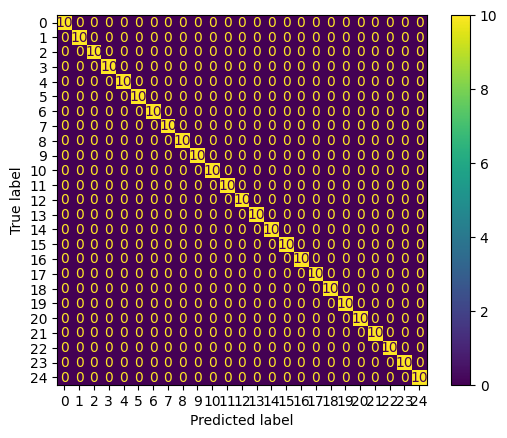

In [10]:
logit_m = LogisticRegression(**lr_res.best_params_)
logit_m.fit(train_test_dict['train_x'], train_test_dict['train_y'])
y_hat = logit_m.predict(train_test_dict['train_x'])
y_logit = logit_m.predict(train_test_dict['test_x'])
print('Training set accuracy: ', accuracy_score(train_test_dict['train_y'], y_hat))
print('Test set accuracy: ',accuracy_score(train_test_dict['test_y'], y_logit))
plot_confusion_matrix(logit_m, train_test_dict['test_x'], train_test_dict['test_y'])
print(classification_report(train_test_dict['test_y'], y_logit))
plt.show()


#### Support Vector Machine Hyperparams Tuning 

In [11]:
svc = SVC()

svc_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
svc_Cv = GridSearchCV(svc, svc_grid, refit = True, verbose = 3)
 

svc_res =svc_Cv.fit(train_test_dict['train_x'], train_test_dict['train_y'])

print(svc_res.best_params_)

print(svc_res.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.995 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.990 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.980 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.990 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.990 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.980 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.965 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.975 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

#### Support Vector Machine Modeling

- Best params : {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

Training set accuracy:  0.999
Test set accuracy:  0.996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00  

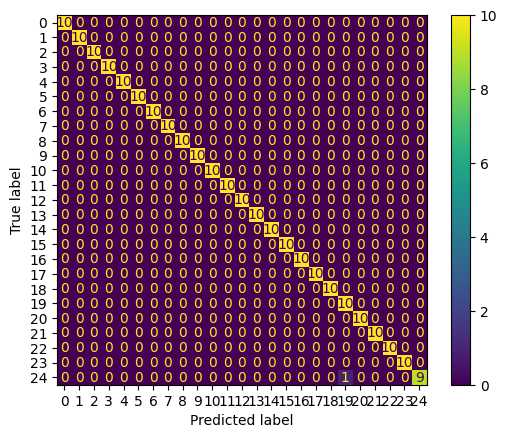

In [12]:
svc = SVC(**svc_res.best_params_)

svc.fit(train_test_dict['train_x'], train_test_dict['train_y'])
y_hat = svc.predict(train_test_dict['train_x'])
y_svc = svc.predict(train_test_dict['test_x'])
print('Training set accuracy: ', accuracy_score(train_test_dict['train_y'], y_hat))
print('Test set accuracy: ',accuracy_score(train_test_dict['test_y'], y_svc))
plot_confusion_matrix(svc, train_test_dict['test_x'], train_test_dict['test_y'])
print(classification_report(train_test_dict['test_y'], y_svc))
plt.show()


#### DecisionTree Classifier Hyperparams Tuning 

In [13]:
dt = DecisionTreeClassifier()
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
dt_cv = GridSearchCV(estimator=dt, param_grid=params, cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")


dt_res =dt_cv.fit(train_test_dict['train_x'], train_test_dict['train_y'])

print("Best: %f using %s" % (dt_res.best_score_, dt_res.best_params_))

means = dt_res.cv_results_['mean_test_score']
stds = dt_res.cv_results_['std_test_score']
params = dt_res.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best: 0.986000 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 20}
0.156000 (0.004000) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5}
0.158000 (0.003464) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.160000 (0.000000) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 20}
0.160000 (0.000000) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 50}
0.160000 (0.000000) with: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 100}
0.307000 (0.020273) with: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
0.276000 (0.004000) with: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.287000 (0.017059) with: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}
0.299000 (0.019053) with: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 50}
0.200000 (0.000000) with: {'criterion': 'gini', 'max_depth':

#### Decision Tree Classifier Modeling

- Best params : {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}

Training set accuracy:  0.993
Test set accuracy:  0.992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00  

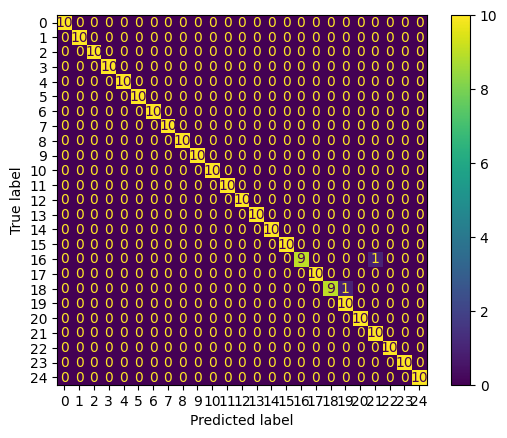

In [14]:
dtc = DecisionTreeClassifier(**dt_res.best_params_)

dtc.fit(train_test_dict['train_x'], train_test_dict['train_y'])
y_hat = dtc.predict(train_test_dict['train_x'])
y_dtc = dtc.predict(train_test_dict['test_x'])
print('Training set accuracy: ', accuracy_score(train_test_dict['train_y'], y_hat))
print('Test set accuracy: ',accuracy_score(train_test_dict['test_y'], y_dtc))
plot_confusion_matrix(dtc, train_test_dict['test_x'], train_test_dict['test_y'])
print(classification_report(train_test_dict['test_y'], y_dtc))
plt.show()

#### RandomForest Classifier Hyperparams Tuning
    - Randomized Search 사용하여 Hyper parameter Tuning 진행함 

In [15]:
random_grid = {
'n_estimators': [20,50,100,150,200,300,500],
'max_features': ['auto', 'sqrt'],
'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
'min_samples_split':  [2, 6, 10],
'min_samples_leaf': [1, 3, 4],
'bootstrap': [True, False]}

rf = RandomForestClassifier() #creating base model

rf_cv = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_res =rf_cv.fit(train_test_dict['train_x'], train_test_dict['train_y'])

print("Best: %f using %s" % (rf_res.best_score_, rf_res.best_params_))

means = rf_res.cv_results_['mean_test_score']
stds = rf_res.cv_results_['std_test_score']
params = rf_res.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best: 0.993000 using {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
0.981000 (0.009695) with: {'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 120, 'bootstrap': False}
0.985000 (0.007071) with: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
0.988000 (0.007483) with: {'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
0.978000 (0.007483) with: {'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
0.991000 (0.008602) with: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': True}
0.992000

#### RandomForest Classifier Modeling

- Best params : {'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 120, 'bootstrap': False}

Training set accuracy:  1.0
Test set accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      

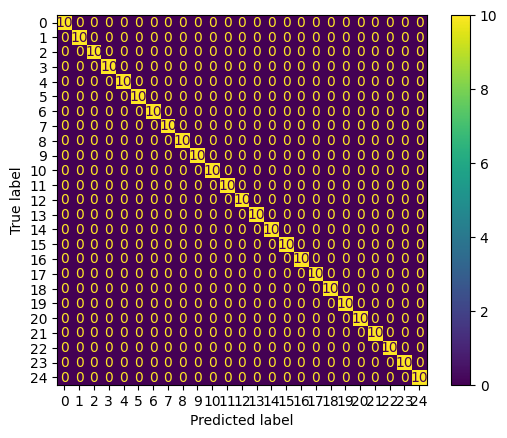

In [16]:
rdf = RandomForestClassifier(**rf_res.best_params_)

rdf.fit(train_test_dict['train_x'], train_test_dict['train_y'])
y_hat = rdf.predict(train_test_dict['train_x'])
y_rdf = rdf.predict(train_test_dict['test_x'])
print('Training set accuracy: ', accuracy_score(train_test_dict['train_y'], y_hat))
print('Test set accuracy: ',accuracy_score(train_test_dict['test_y'], y_rdf))
plot_confusion_matrix(rdf, train_test_dict['test_x'], train_test_dict['test_y'])
print(classification_report(train_test_dict['test_y'], y_rdf))
plt.show()

#### Boosting Classifier Hyperparams Tuning
    - Model : Boosting 계열 XGBoost model을 사용함 

In [17]:
import xgboost as xgb


xgb_params = {'max_depth': [3, 6, 10, 15],
         'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
         'subsample': np.arange(0.5, 1.0, 0.1),
         'colsample_bytree': np.arange(0.5, 1.0, 0.1),
         'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
         'n_estimators': [100, 250, 500, 750],
         'num_class': [10]}

xgbclf = xgb.XGBClassifier(objective="multi:softmax", tree_method='hist')
xgb_cv = RandomizedSearchCV(estimator=xgbclf, param_distributions=xgb_params, scoring='accuracy',n_iter=25,n_jobs=4, verbose=1)

xgb_res =xgb_cv.fit(train_test_dict['train_x'], train_test_dict['train_y'])

print("Best: %f using %s" % (xgb_res.best_score_, xgb_res.best_params_))

means = xgb_res.cv_results_['mean_test_score']
stds = xgb_res.cv_results_['std_test_score']
params = xgb_res.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[15:33:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.976000 using {'subsample': 0.8999999999999999, 'num_class': 10, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8999999999999999}
0.968000 (0.010770) with: {'subsample': 0.6, 'num_class': 10, 'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6}
0.974000 (0.008602) with: {'subsample': 0.7999999999999999, 'num_class': 10, 'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8999999999999999}
0.965000 (0.010954) with: {'subsample': 0.7, 'num_clas

#### Boosting Classifier Modeling

- Model : XGBoost
- Best params : {'subsample': 0.8, 'num_class': 10, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8}

[15:33:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training set accuracy:  1.0
Test set accuracy:  0.996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1

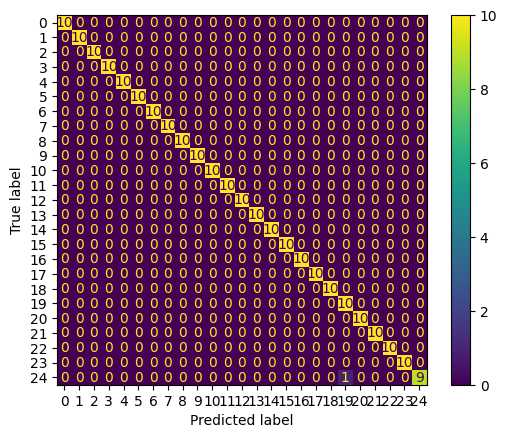

In [18]:

xgb_clf = xgb.XGBClassifier(**xgb_res.best_params_)

xgb_clf.fit(train_test_dict['train_x'], train_test_dict['train_y'])
y_hat = xgb_clf.predict(train_test_dict['train_x'])
y_xgb = xgb_clf.predict(train_test_dict['test_x'])
print('Training set accuracy: ', accuracy_score(train_test_dict['train_y'], y_hat))
print('Test set accuracy: ',accuracy_score(train_test_dict['test_y'], y_xgb))
plot_confusion_matrix(xgb_clf, train_test_dict['test_x'], train_test_dict['test_y'])
print(classification_report(train_test_dict['test_y'], y_xgb))
plt.show()

In [19]:
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint

from tensorflow.keras import backend as K

In [20]:
def DNN(Numclass, lr= 0.01):
    try:

        model = Sequential()
        model.add(layers.Dense(32, input_shape=(4,)))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))

        model.add(layers.Dense(64))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))

        model.add(layers.Dense(128))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))

        
        model.add(layers.Dense(64))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))

        model.add(layers.Dense(32))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))

        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(Numclass))
        model.add(layers.Activation('softmax'))


        optimizer = Adam(lr)

        model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

        model.summary()
        return model
    except Exception as e:
        print(e)


In [21]:
def learning_model(model, X_train, y_train):

    rlr_call = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=4, verbose=1)

    es = EarlyStopping(monitor="val_loss",
                    patience=10,
                    verbose=1,
                    mode="min",
                    restore_best_weights=True,)

    history = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_split=0.2, verbose=2, callbacks=[rlr_call, es])

    return history


In [22]:
model = DNN(Numclass=25, lr=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 64)                0

In [23]:
# re_x_train = np.reshape(train_test_dict['train_x'], (train_test_dict['train_x'].shape[0],train_test_dict['train_x'].shape[1], 1))
# re_x_test = np.reshape(train_test_dict['test_x'], (train_test_dict['test_x'].shape[0],train_test_dict['test_x'].shape[1], 1))
from tensorflow.keras.utils import to_categorical

history= learning_model(model=model, X_train=train_test_dict['train_x'], y_train=train_test_dict['train_y'])

Epoch 1/100
8/8 - 2s - loss: 3.0649 - accuracy: 0.1200 - val_loss: 3.2039 - val_accuracy: 0.0850 - lr: 0.0010 - 2s/epoch - 259ms/step
Epoch 2/100
8/8 - 0s - loss: 2.3157 - accuracy: 0.3550 - val_loss: 3.1720 - val_accuracy: 0.1050 - lr: 0.0010 - 48ms/epoch - 6ms/step
Epoch 3/100
8/8 - 0s - loss: 2.0298 - accuracy: 0.5150 - val_loss: 3.1476 - val_accuracy: 0.1750 - lr: 0.0010 - 41ms/epoch - 5ms/step
Epoch 4/100
8/8 - 0s - loss: 1.8478 - accuracy: 0.5688 - val_loss: 3.1315 - val_accuracy: 0.2650 - lr: 0.0010 - 40ms/epoch - 5ms/step
Epoch 5/100
8/8 - 0s - loss: 1.7110 - accuracy: 0.6250 - val_loss: 3.1192 - val_accuracy: 0.2650 - lr: 0.0010 - 41ms/epoch - 5ms/step
Epoch 6/100
8/8 - 0s - loss: 1.5483 - accuracy: 0.7237 - val_loss: 3.1039 - val_accuracy: 0.2500 - lr: 0.0010 - 49ms/epoch - 6ms/step
Epoch 7/100
8/8 - 0s - loss: 1.5170 - accuracy: 0.7200 - val_loss: 3.0802 - val_accuracy: 0.2450 - lr: 0.0010 - 52ms/epoch - 7ms/step
Epoch 8/100
8/8 - 0s - loss: 1.3268 - accuracy: 0.8000 - val_l

In [24]:
def plot_loss(history, title=None):
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc=0)

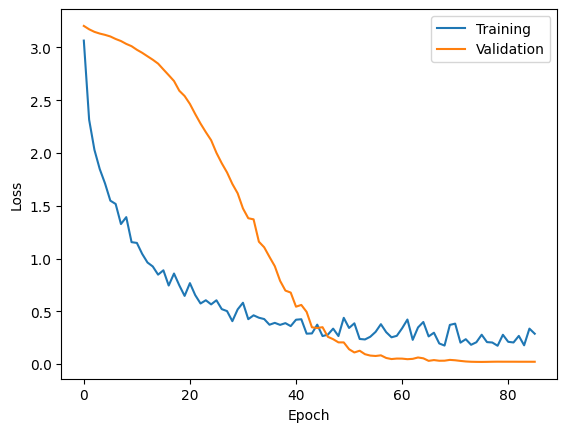

8/8 [==============================] - 0s 1ms/step
Test set accuracy:  0.996
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0  0

In [25]:
plot_loss(history=history)
plt.show()
predictions = model.predict(train_test_dict['test_x'])
pred_classes = np.argmax(predictions, axis=-1)
print('Test set accuracy: ',accuracy_score(train_test_dict['test_y'], pred_classes))
print(confusion_matrix(train_test_dict['test_y'], pred_classes, labels=list(range(25))))

print(classification_report(train_test_dict['test_y'], pred_classes))
